In [1]:
import pandas as pd
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
exp = MultiVarExperiment("ERA5", "plev", ["u", "v", "s"], "6H", "all", None, -80, 40, 15, 80, [175, 200, 225, 250, 300, 350])

all_jets_one_df, where_are_jets, all_jets_one_array, all_jets_over_time, flags = exp.track_jets(processes=N_WORKERS, chunksize=100)
props_as_ds_uncat = exp.props_as_ds(False, processes=N_WORKERS, chunksize=100)
props_as_ds = exp.props_as_ds(True, processes=N_WORKERS, chunksize=100)

ds = exp.ds
da = exp.ds["s"]
jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)

da_pvs = Experiment("ERA5", "surf", "pvs", "6H", "all", None, *exp.region, 250, "hourofyear", {"hourofyear": ("win", 60)}).da
events = pd.read_parquet(f'{DATADIR}/ERA5/RWB_index/era5_pv_streamers_350K_1959-2022.parquet')
da_anti = da_pvs.sel(type="anti")
da_cycl = da_pvs.sel(type="cycl")
events_mask_anti = da_anti.any(['lon', 'lat']).values
events_mask_cycl = da_cycl.any(['lon', 'lat']).values
events_indices_anti = np.where(events_mask_anti)[0]
events_indices_cycl = np.where(events_mask_cycl)[0]

# Event near jet like width

In [93]:
def get_wb_props(jet: pd.DataFrame, da_pvs: xr.DataArray, every: int = 5):
    jet = jet.iloc[::every]
    lo, la = jet[["lon", "lat"]].to_numpy().T
    dxds = np.gradient(lo)
    dyds = np.gradient(la)
    theta = np.arctan2(dyds, dxds)

    distances = np.full((len(jet), 2), fill_value=-1)
    intensities = np.zeros((len(jet), 2))
    jet_pvs = slice_1d(
        da_pvs, {"lon": lo, "lat": la}
    ).values.T
    up_or_down = np.argmax(np.abs(jet_pvs), axis=1)
    jet_pvs = np.take_along_axis(jet_pvs, up_or_down[:, None], axis=1).flatten()
    distances[np.where(jet_pvs)[0], :] = 0.
    intensities[np.where(jet_pvs)[0], :] = jet_pvs[np.where(jet_pvs)[0], None]

    dn = 2
    t_ = np.arange(dn, 20 + dn, dn)

    for k in range(len(jet)):
        if any(distances[k] != -1):
            continue 
        for l, side in enumerate([-1, 1]):
            t = side * t_
            normallons = np.cos(theta[k] + np.pi / 2) * t + lo[k]
            normallats = np.sin(theta[k] + np.pi / 2) * t + la[k]
            mask_valid = (
                (normallons >= lon.min())
                & (normallons <= lon.max())
                & (normallats >= lat.min())
                & (normallats <= lat.max())
            )
            if np.sum(mask_valid) == 0:
                continue
            normallons = normallons[mask_valid]
            normallats = normallats[mask_valid]
            normal_pvs = slice_1d(
                da_pvs, {"lon": normallons, "lat": normallats}
            ).values
            for type_ in [0, 1]:
                if not any(normal_pvs[type_]):
                    continue
                imin = np.argmax(normal_pvs[type_] != 0)
                distance = haversine(lo[k], la[k], normallons[imin], normallats[imin])
                reject_new = (distance >= distances[k, l]) and (distances[k, l] != -1)
                if reject_new:
                    continue
                distances[k, l] = distance
                intensities[k, l] = normal_pvs[type_][imin]
            
    props = {}
    props["above"] = np.sum(np.abs(intensities[k, 0])) < np.sum(np.abs(intensities[k, 1]))
    dists_good_direction = distances[:, int(props["above"])]
    props["affected_from"] = np.argmax(dists_good_direction != -1)
    props["affected_until"] = len(jet) - np.argmax(dists_good_direction[::-1] != -1) - 1
    slice_ = slice(props["affected_from"], props["affected_until"] + 1)
    props["mean_int"] = np.mean(intensities[slice_, int(props["above"])])
    props["mean_dist"] = np.mean(dists_good_direction[slice_])
    props["affected_from"] = props["affected_from"] * every
    props["affected_until"] = props["affected_until"] * every
    return props

In [95]:
lon, lat = da_anti.lon.values, da_anti.lat.values
names = ["above", "affected_from", "affected_until", "mean_int", "mean_dist"]
dtypes = [bool, np.uint16, np.uint16, np.float32, np.float32]
da_template = props_as_ds_uncat["mean_lat"].copy()
da_template = da_template.where(da_template.isnull(), 0)
wb_props_uncat = xr.Dataset({name: da_template.astype(dtype) for name, dtype in zip(names, dtypes)})

for i, (time, jets) in enumerate(all_jets_one_df.groupby(level=0)):
    if i not in events_indices_anti and i not in events_indices_cycl:
        continue
    
    jets = jets.droplevel(0)
    for j, (jet_name, jet) in enumerate(jets.groupby(level=0)):
        props = get_wb_props(jet, da_pvs.isel(time=i), every=3)
        for key, value in props.items():
            wb_props_uncat[key][i, j] = value
    if i > 50:
        break

/storage/homefs/hb22g102/miniforge3/envs/env11_2/lib/python3.11/site-packages/xarray/core/duck_array_ops.py:239: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


In [82]:
wb_props_uncat.isel(time=i)

<xarray.Dataset> Size: 281B
Dimensions:         (jet: 13)
Coordinates:
  * jet             (jet) int64 104B 0 1 2 3 4 5 6 7 8 9 10 11 12
    time            datetime64[ns] 8B 1959-01-03T12:00:00
Data variables:
    above           (jet) bool 13B True False False True ... True True True True
    affected_from   (jet) uint16 26B 7 0 0 0 0 22 0 0 0 0 0 0 0
    affected_until  (jet) uint16 26B 44 6 23 37 41 57 0 0 0 0 0 0 0
    mean_int        (jet) float32 52B -0.005551 -0.004784 -0.002501 ... nan nan
    mean_dist       (jet) float32 52B 2.108e+05 0.0 -0.5 ... nan nan nan

# With mask_pvs

In [76]:
def mask_pvs(
    da: xr.DataArray | xr.Dataset,
    events: pd.DataFrame,
    da_anti: xr.DataArray,
    offsets: Sequence | None = None,
    q: float = 0.9,
) -> xr.DataArray:
    if offsets is None:
        offsets = np.arange(24)
    da_masked = None
    for offset in tqdm(offsets):
        if da_masked is None:
            events_ = events.iloc[events["date"].isin(da_anti.time.values[events_mask]).values]
            events_com_x = np.stack(events_["com"].values)[:, 0]
            events_com_y = np.stack(events_["com"].values)[:, 1]
            masks = {
                "west": events_com_x < np.quantile(events_com_x, 1 - q),
                "east": events_com_x > np.quantile(events_com_x, q),
                "south": events_com_y < np.quantile(events_com_y, 1 - q),
                "north": events_com_y > np.quantile(events_com_y, q),
                "intense": (
                    events_["intensity"] > np.quantile(events_["intensity"], q)
                ).values,
                "large": (
                    events_["event_area"] > np.quantile(events_["event_area"], q)
                ).values,
            }
            base_coords = {dim: getattr(da, dim).values for dim in da.dims if dim != "time"}
            coords = {
                "event_type": ["all"] + list(masks),
                "time_around_event": offsets,
            } | base_coords
            da_masked = xr.DataArray(
                data=np.zeros([len(c) for c in coords.values()]) + np.nan, coords=coords
            )
            if isinstance(da, xr.Dataset):
                da_masked = xr.Dataset({varname: da_masked.copy() for varname in da.data_vars})
            masks["all"] = np.ones_like(masks["west"], dtype=bool)
        for event_type, mask in masks.items():
            if event_type == "all":
                times = np.unique(events_["date"]) + offset * np.timedelta64(6, "h")
            else:
                times = np.unique(events_[mask]["date"]) + offset * np.timedelta64(6, "h")
            times = times[np.isin(times, da.time)]
            da_masked.loc[dict(event_type=event_type, time_around_event=offset)] = da.loc[dict(time=times)].mean(dim="time")
    return da_masked

In [66]:
da_masked = mask_pvs(da, events, da_anti, offsets=np.arange(0, 25, 4))

100%|██████████| 7/7 [03:58<00:00, 34.04s/it]


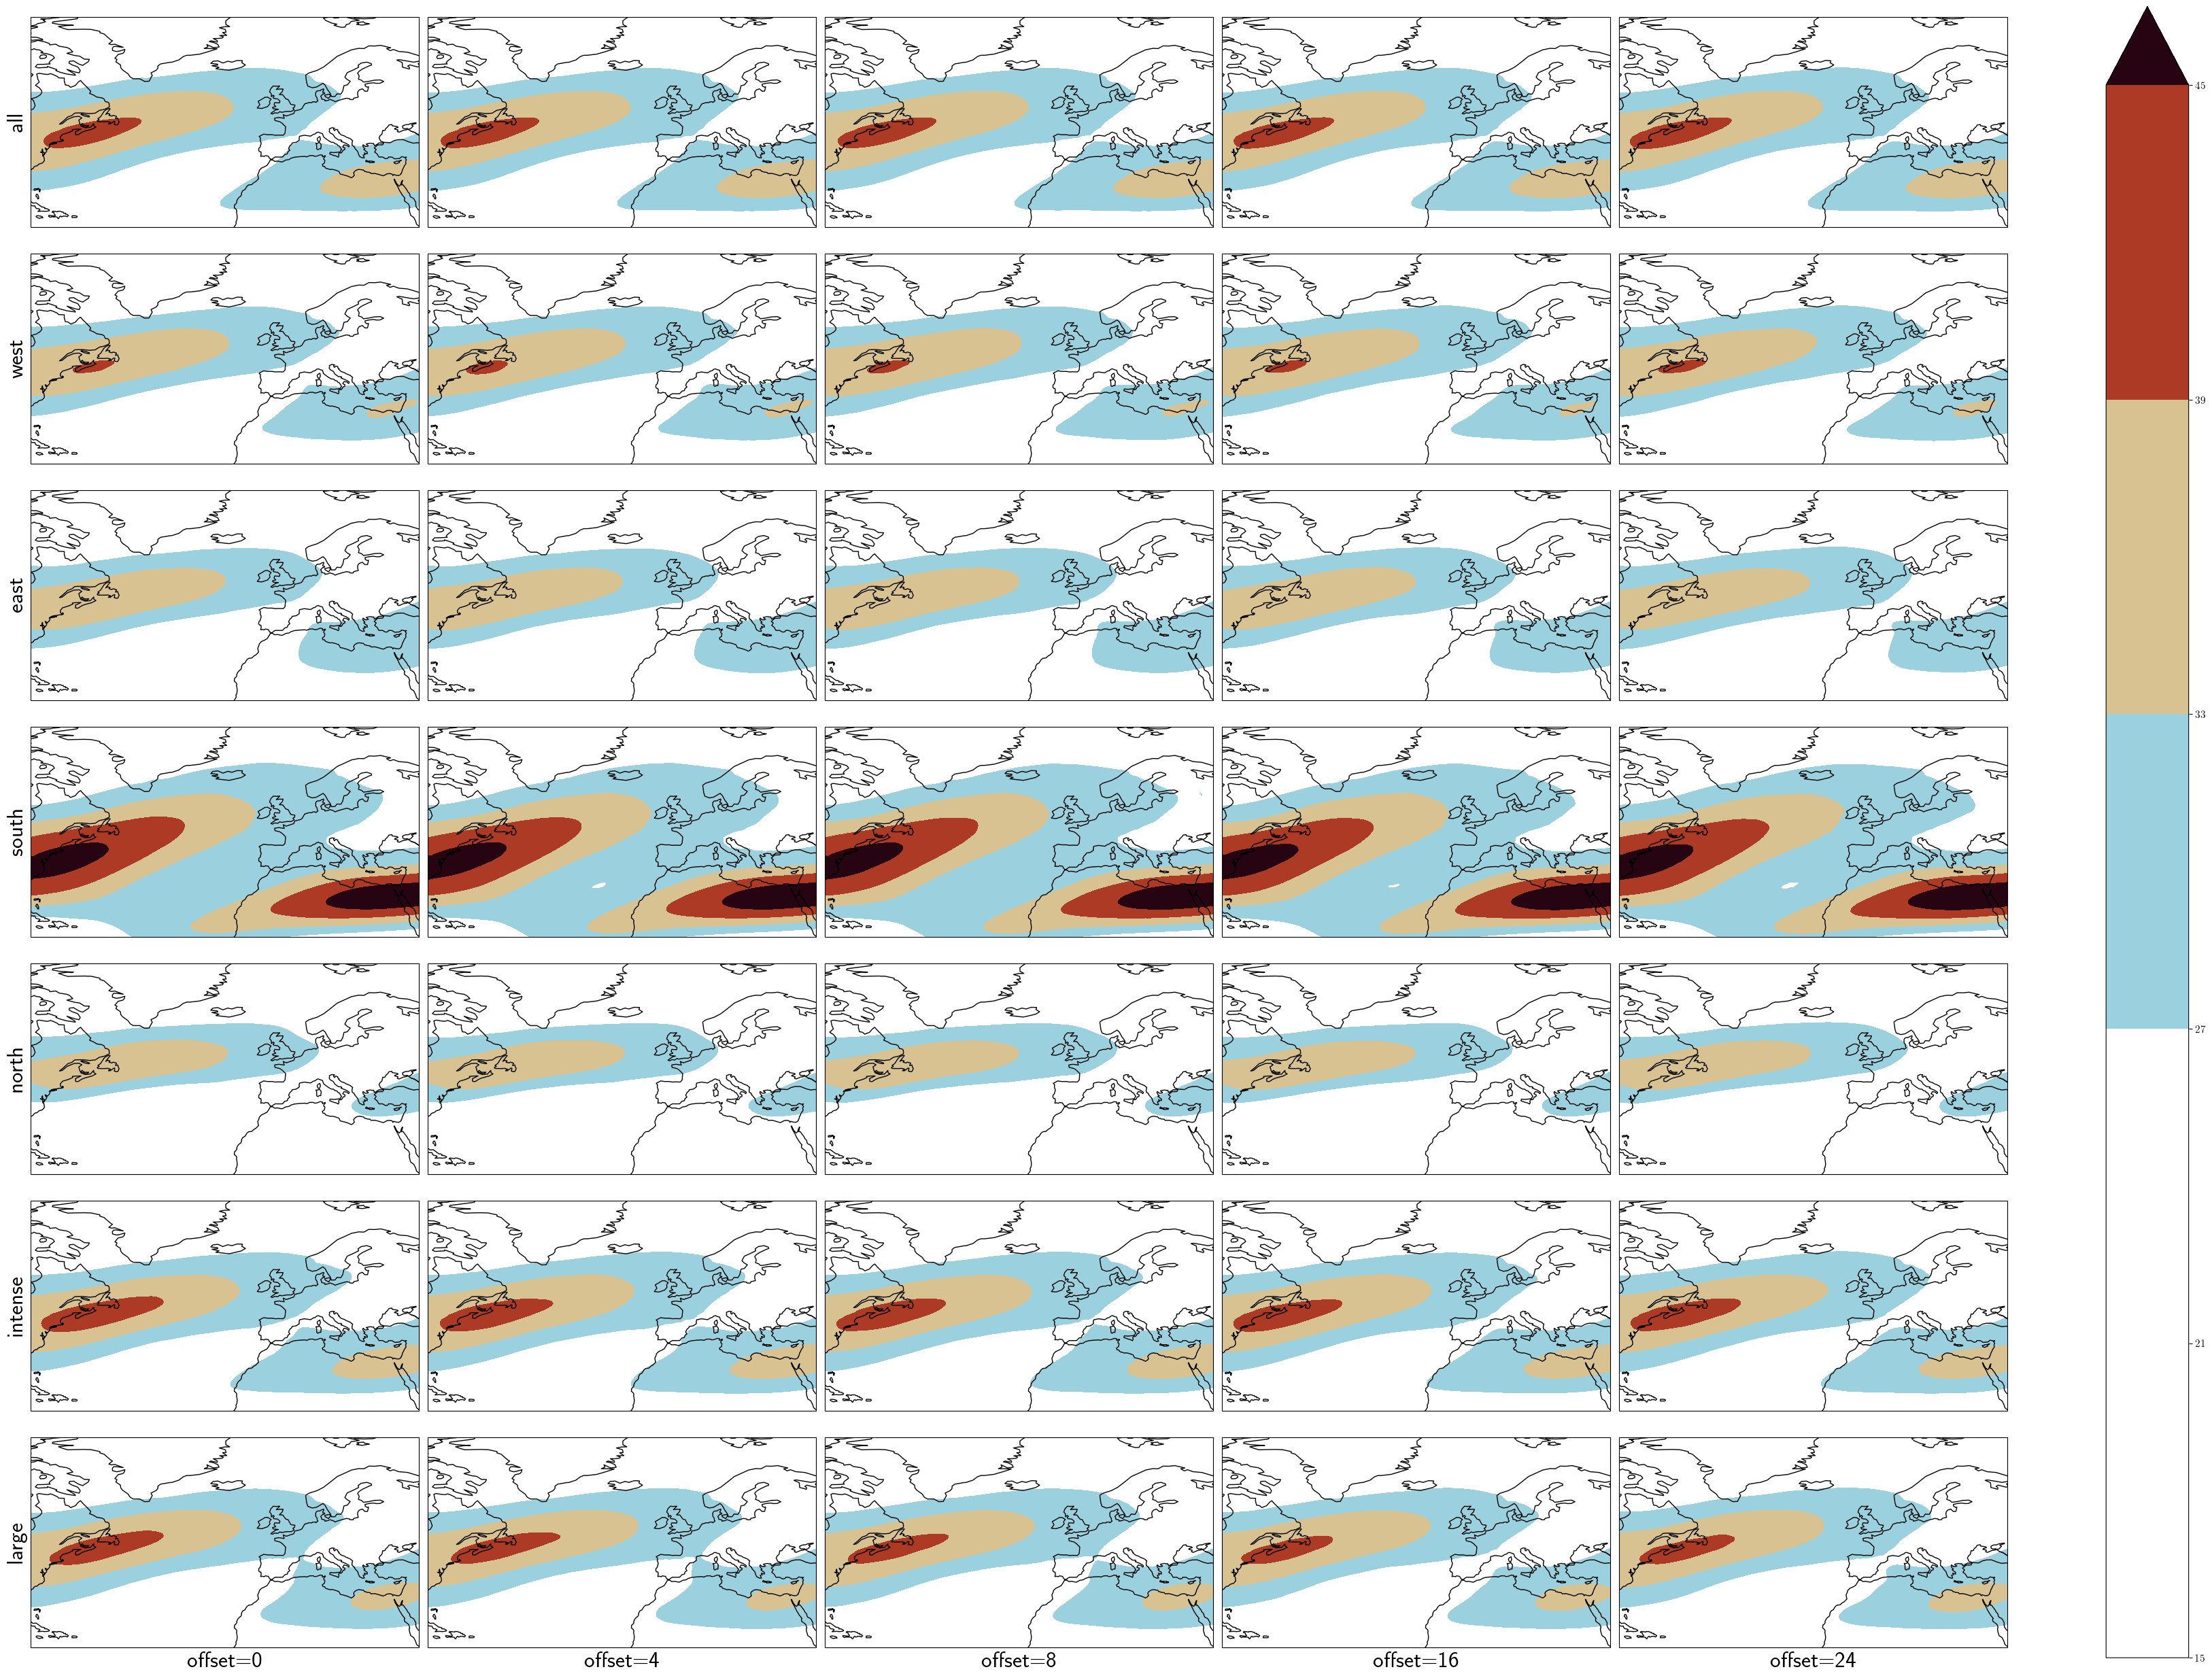

In [67]:
offsets = [0, 4, 8, 16, 24]
clu = Clusterplot(len(da_masked.event_type), len(offsets), region=get_region(da_masked))
_ = clu.add_contourf([da_masked.loc[event_type, offset] for event_type in da_masked.event_type for offset in offsets], transparify=2, q=0.99)
for i, event_type in enumerate(da_masked.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_masked.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [68]:
da_jp_masked = mask_pvs(jet_pos_da, events, da_anti)

100%|██████████| 24/24 [01:33<00:00,  3.88s/it]


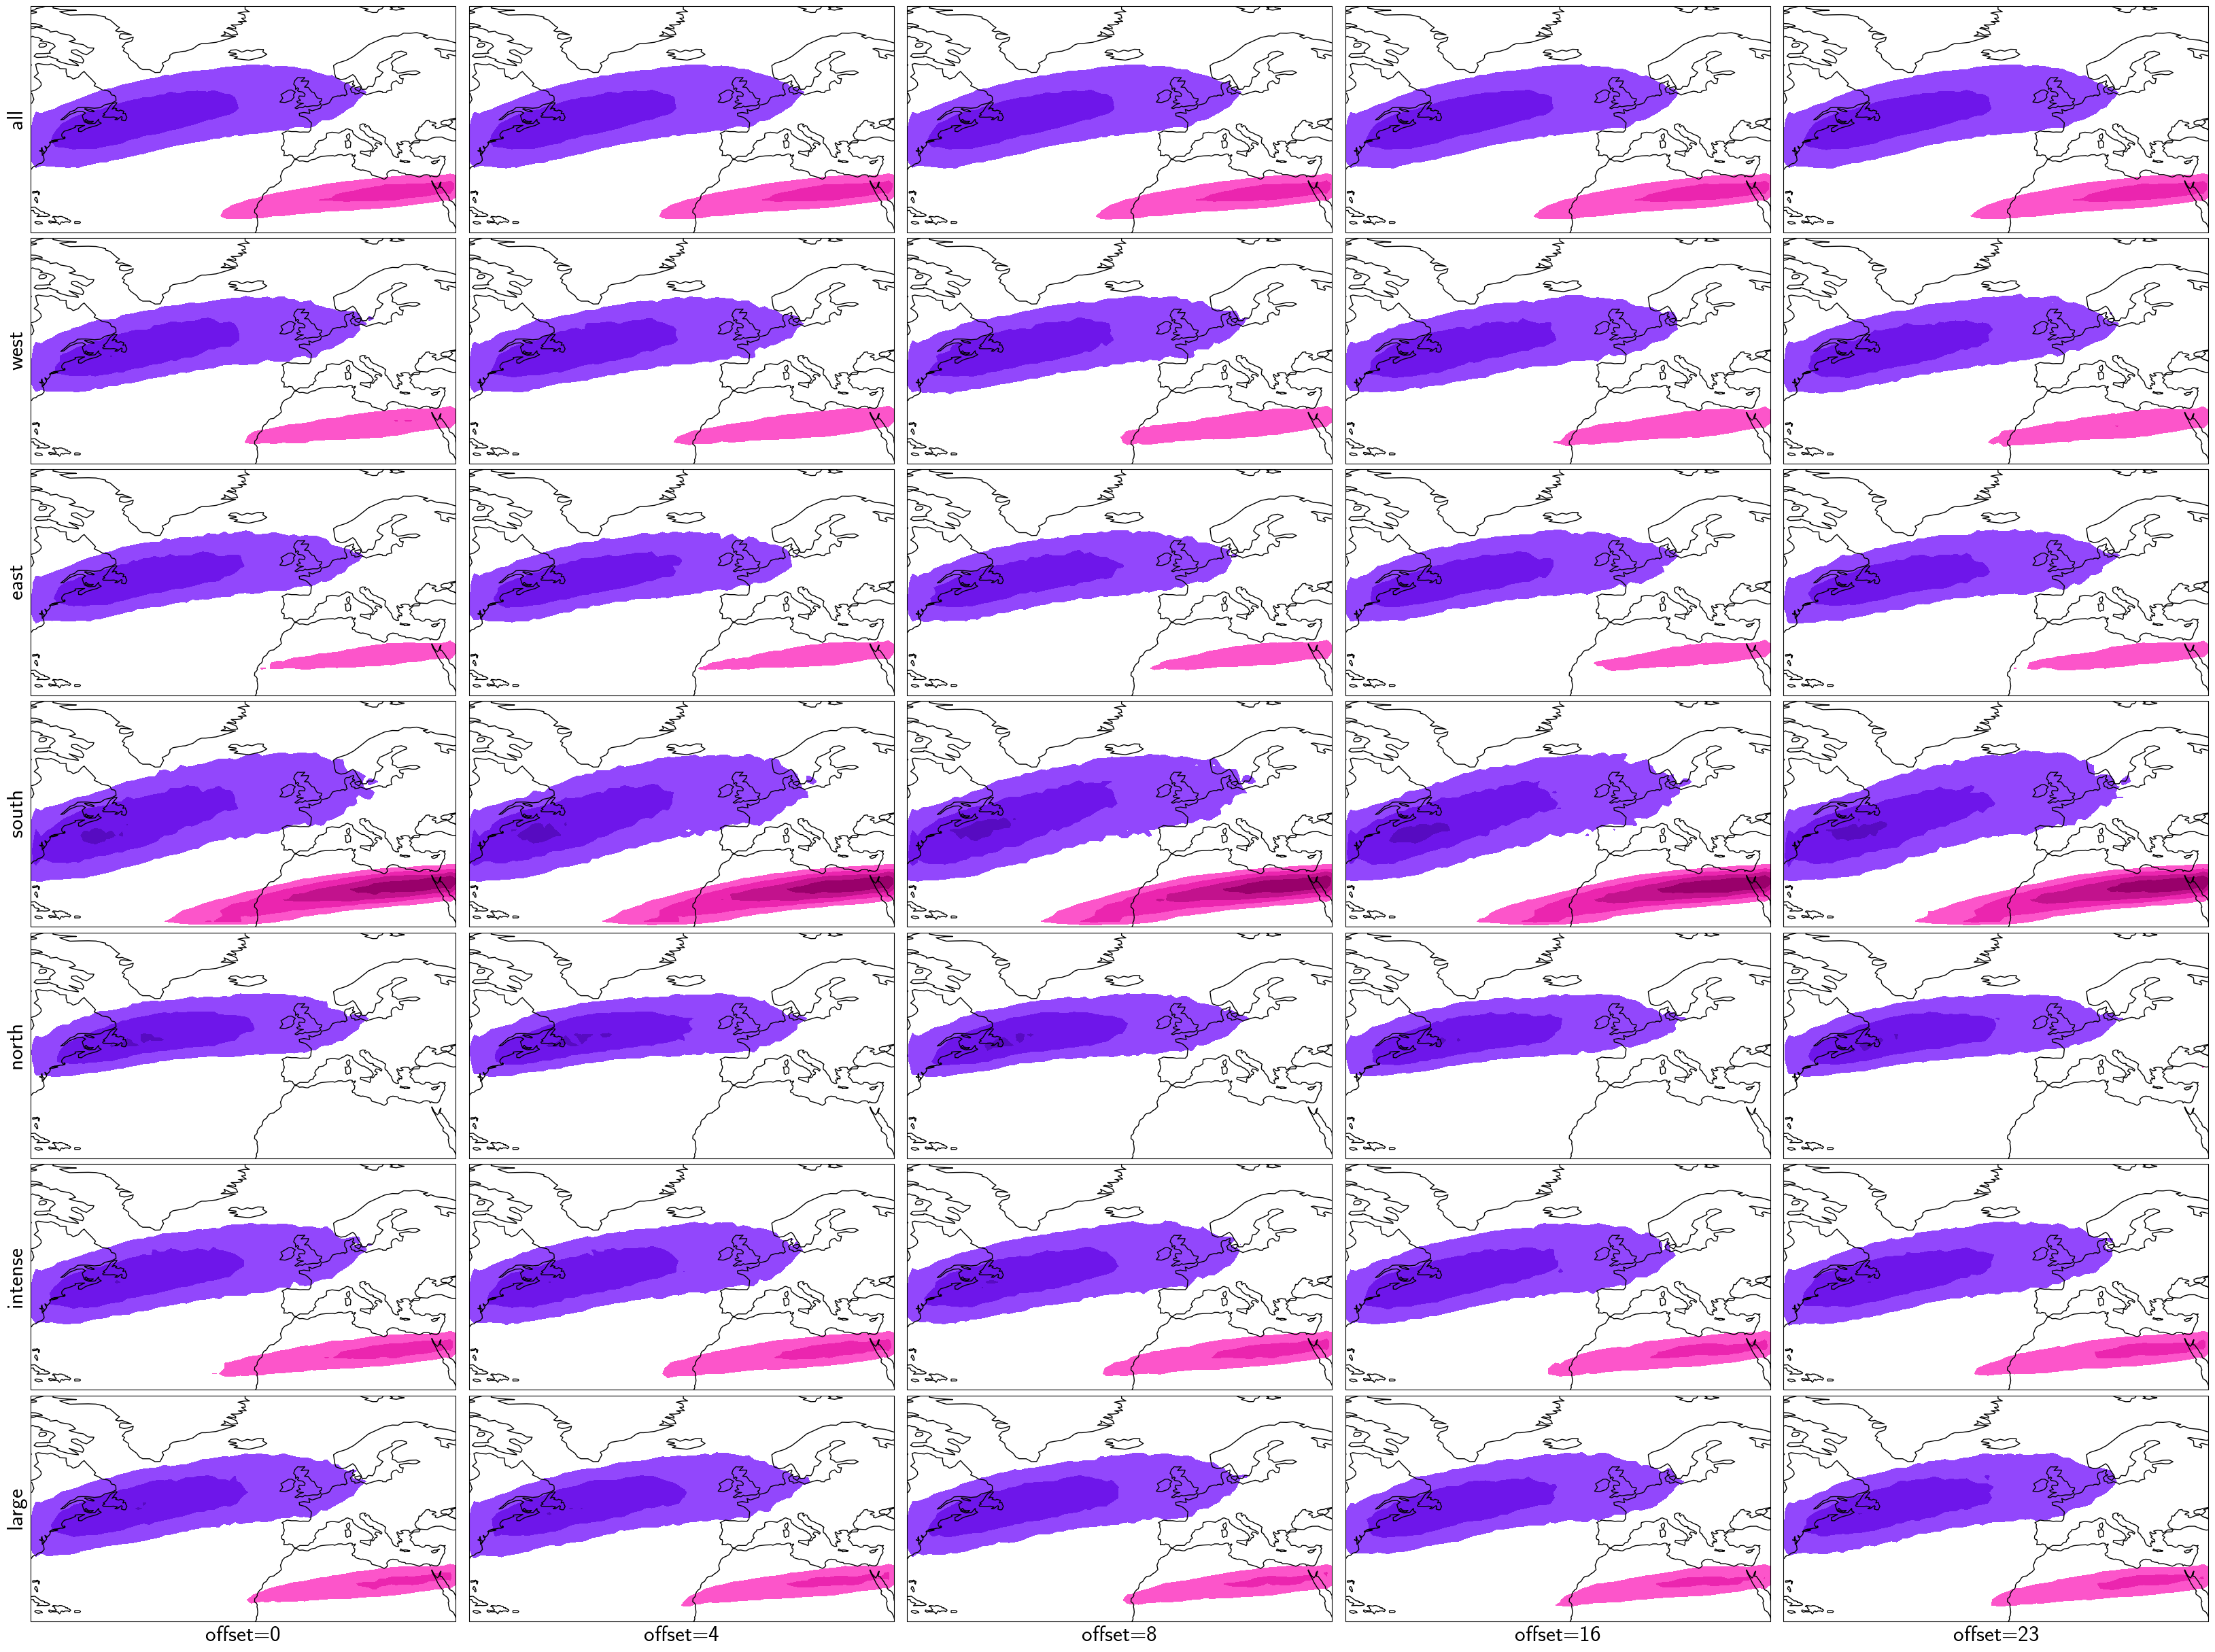

In [69]:
offsets = [0, 4, 8, 16, 23]
clu = Clusterplot(len(da_jp_masked.event_type), len(offsets), region=get_region(da_jp_masked))
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'subtropical'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap=MYPINKS, draw_cbar=False)
_ = clu.add_contourf([da_jp_masked.loc[event_type, offset, 'polar'] for event_type in da_jp_masked.event_type for offset in offsets], transparify=2, q=0.99, cmap=MYPURPLES, draw_cbar=False)
for i, event_type in enumerate(da_jp_masked.event_type.values):
    k = len(offsets) * i
    clu.axes[k].set_yticks([])
    clu.axes[k].set_ylabel(event_type, fontsize=24)
for i, offset in enumerate(offsets):
    k = len(offsets) * (len(da_jp_masked.event_type) - 1) + i
    clu.axes[k].set_xticks([])
    clu.axes[k].set_xlabel(f"{offset=}", fontsize=24)

In [92]:
props_as_ds_anoms, props_as_ds_clims = compute_anomalies_ds(props_as_ds, "hourofyear", normalized=True, return_clim=True)

In [93]:
props_as_ds_masked = mask_pvs(props_as_ds_anoms, events, da_anti, np.arange(-24, 25, 4))

100%|██████████| 13/13 [00:09<00:00,  1.35it/s]


In [96]:
fig, axes = plt.subplots(len(props_as_ds_masked.data_vars), 2, figsize=(12, 30), sharex='all', sharey='all', tight_layout=True)
x = props_as_ds_masked.time_around_event.values
colors = ['blue', 'blue', 'green', 'green', 'red', 'purple']
linestyles = ['dashed', 'solid', 'dashed', 'solid', 'solid', 'solid']
for axs, varname in zip(axes, props_as_ds_masked.data_vars):
    for ax, jet in zip(axs, props_as_ds_masked.jet.values):
        da_ = props_as_ds_masked[varname].sel(jet=jet)
        to_plot = da_.loc[dict(event_type="all")]
        ax.plot(x, to_plot.values, lw=3, color='black', zorder=1000)
        if jet == 'subtropical':
            ax.set_ylabel(varname)
        for event_type, color, linestyle in zip(props_as_ds_masked.event_type.values[1:], colors, linestyles):
            y = da_.sel(event_type=event_type).values
            ax.plot(x, y, label=event_type, lw=3, color=color, linestyle=linestyle)
        ax.grid(True)
axes[0, 0].set_title('Subtropical')
axes[0, 1].set_title('Polar')
axes[-1, 0].set_xlabel('Time around event')
axes[-1, 1].set_xlabel('Time around event')
axes[-1, -1].legend(ncol=3)

NameError: name 'props_as_ds_masked' is not defined